**Estudo das praticas de gestão escolar a partir das notas do SARESP**

*Objetivos da Análise*

*O Desafio Seduc de Dados Abertos foi uma competição promovida pela Secretaria da Educação do Estado de São Paulo, que tinha como objetivo aproximar pessoas que têm experiência com a manipulação de dados aos desafios da Rede Estadual de Ensino!*

*Uma série de bases de dados anonimizadas foi dispnibilizada no Portal de Dados Abertos, com o intuito de responder à seguinte pergunta: "Quais as características da gestão escolar que impactam positivamente no rendimento dos estudantes no SARESP?"*

### Dicionário de dados
Foram disponibilizadas algumas bases de dados e abaixo estarão descritas o que aquelas que serão utilizadas na análise contém, todas elas podem ser encontradas em https://dados.educacao.sp.gov.br/search/type/dataset:

1.   Formação por servidor = Formação funcionários anonimizado (novembro 2018 abril e novembro 2019), dentre as opções estão o grau de escolaridade funcionário a funcionário. Portanto se um determinado servidor possuir mestrado, doutorado ou bacharelado essa informação estará contida nessa base

2.   Ausências por servidor = Ausências funcionários ativos anonimizado. Aqui é possível verificar funcionário a funcionário se ele teve faltas, mesmo que justificadas no período de análise.

3.   Carga Horária por Docente = Carga horária anonimizado docentes ativos. Base com as informações das horas trabalhadas por docente. 

4.   Proeficiência SARESP por escola = O Sistema de Avaliação de Rendimento Escolar do Estado de São Paulo (SARESP) é uma avaliação anual aplicada pela Secretaria da Educação do Estado de São Paulo com a finalidade de diagnosticar e acompanhar a evolução da educação básica paulista. Aqui estarão as notas em português, matemática e ciências para o ensino médio.



### Metodologia
  Como mencionado, para essa atividades, foram selecionadas 3 datasets que serão a base de estudo para a análise em Big Data : **Ausências, Formação e Carga Horária**. A ideia é entender de forma geral se as escolas que possuem as maiores médias de Carga Horária são também as escolas com maior nota no Saresp, se as escolas com os funcionários de maior formação são as escola com maior nota e por fim se as escolas com menor ausência estão entre as escolas que melhor performam e por fim almeja-se entender qual desses é o mais relevante nas escolas de melhor média no SARESP.

As bases podem ser encontradas no Drive: https://drive.google.com/drive/folders/1hDsD3NX95bz3iTzRFQ29LZoZ6hpofyQr?usp=sharing 

Esse script em formato notebook pode ser encontrado em: https://github.com/felipemoreia/infinet_hadoop


### Passo 1 da Análise dos Dados

Foi feito o upload dos dados para o cluster de máquina virtual e individualmente eles foram descompatados e enviados ao Sistema de Arquivos Distribuídos do Hadoop HDFS. Abaixo seguem os comandos de cada um dos passos para os 4 arquivos

```
unzip saresp.zip -d saresp
HDFS DFS -PUT saresp/
```
```
unzip ausencias.zip -d ausencias\
HDFS DFS -PUT ausencias/
```
```
unzip cargahoraria.zip -d cargahoraria\
HDFS DFS -PUT cargahoraria/
```
```
unzip formacao.zip -d formacao\
HDFS DFS -PUT formacao/
```

Abaixo é possível visualizar os 4 arquivos já descompactados no HDFS

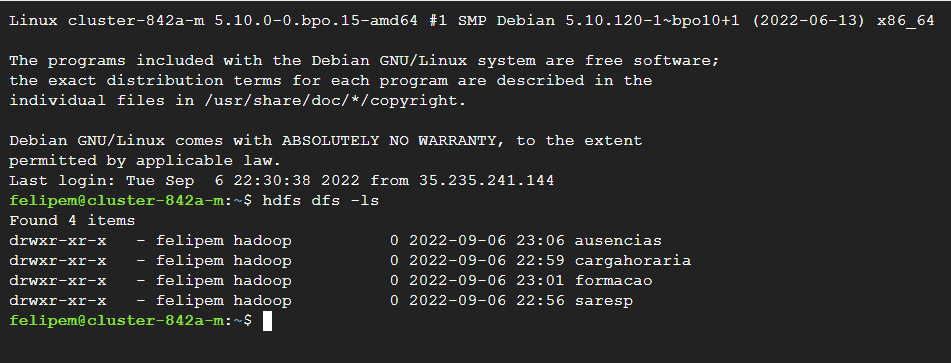

### Passo 2 da Análise de Dados

Uma vez no HDFS será possível analisar esses dados de forma simples e através de uma interface SQL se criarmos tabelas Hive para cada uma delas e abastecermo-as com os dados do sistema de arquivos distribuídos. Para isso, criou-se o modelo lógico das tabelas e o caminho dos arquivos foi apontado para cada uma dessas tabelas criadas. Abaixo seguem os códigos de criação das 4 tabelas, uma para cada pasta no HDFS.

```
CREATE TABLE saresp (DEPADM INT,DepBol INT,NomeDepBol STRING,CodRMet INT,CODESC INT,NOMESC STRING,
SERIEANO STRING,codper INT,periodo STRING,cocomp INT,dscomp STRING,medprof FLOAT)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ';'
STORED AS TEXTFILE;

LOAD DATA INPATH '/user/felipem/saresp/*' overwrite into table saresp;
```

```
CREATE TABLE cargahoraria(REGIAO STRING, NOMEDE STRING, CDINEP INT, CODESC INT, CATESC INT, 
TPESC INT, UA INT, NOMEESC STRING, NMMUNICIPIO STRING, MODAL STRING, CARGOC INT, NMCARGOC STRING, 
CODMAE INT, DENCODMAE STRING, CICLO STRING, MATERIA INT, DENMATERIA STRING, TOTAULALIVRE INT,
TOTAULASUBST INT, TOTGERALAULA INT, TOTAULALIVRENOTURNO INT, TOTAULASUBSTNOTURNO INT, 
TOTAULASNOTURNO INT, JORNADA STRING, idinterno INT)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ';'
STORED AS TEXTFILE;

LOAD DATA INPATH '/user/felipem/cargahoraria/*' overwrite into table cargahoraria;
```

```
CREATE TABLE formacao (REGIAOEXERC STRING, DEEXERC STRING, CIEESCOLA INT, UAEXERC INT, 
NOMEUAEXERC STRING, MUNICIPIOEXERC STRING, DI INT, QUADROC STRING, 
CARGOC INT, NMCARGOC STRING, CATEGC STRING, QUADROE STRING, CARGOE INT, 
NMCARGOE STRING, CATEGE INT, FORMACAO STRING, IDINTERNO INT)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ';'
STORED AS TEXTFILE;

LOAD DATA INPATH '/user/felipem/formacao/*' overwrite into table formacao;
```

```
CREATE TABLE ausencias (REGIAOEXERC STRING, DEEXERC STRING, CIEESCOLA INT,UAEXERC INT, NOMEUAEXERC STRING, 
MUNICIPIOEXERC STRING, QUADROEXERC STRING, CARGOEXERC INT, NOMECARGOEXERC STRING, CATEGE STRING, 
TTDIASFALTAJUST INT, TTDIASFALTAINJUST INT, TTDIASFALTAABONADA INT, TTDIASLICPREMIO INT, 
TTDIASLICGESTANTE INT, TTDIASLICACIDTRAB INT, TTDIASLICINTERPARTIC INT, TOTALDIASMES INT,
 idinterno INT)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ';'
STORED AS TEXTFILE;

LOAD DATA INPATH '/user/felipem/ausencias/*' overwrite into table ausencias;

```
Ao final do scrip é possível verificar que as 4 tabelas foram criadas no Hive tal como na imagem abaixo


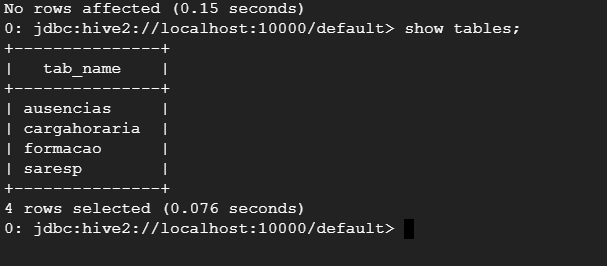

### Passo 3 da Análise de Dados

Pela extensão das bases fez-se necessária a escolha de um método de agrupamento que permitisse a comparação e análise. Nesse caso, escolhemos a média como forma de reduzir os dados. Para cada uma das tabelas foi escolhido um indicador e ao final uma média desse indicador foi criada agrupada por escola. Todas essas análises irão gerar uma nova tabela de médias que servirá para a comparação ao final.


1 - A própria média das notas do indicador SARESP:
```
CREATE TABLE mediacargahoraria as 
SELECT 
  CODESC, 
  AVG(TOTGERALAULA) as medcarga 
FROM 
  cargahoraria 
GROUP BY 
  CODESC;

```

2 - A média da carga horária, do maior para o menor dos professores que trabalham nas escolas:

```
CREATE TABLE mediacargahoraria as 
SELECT 
  CODESC, 
  AVG(TOTGERALAULA) as medcarga 
FROM 
  cargahoraria 
GROUP BY 
  CODESC;

```

3 - A média de formação dos profissionais por escola. Aqui foi feita uma ordenação numérica, afim de que se fosse possível obter a média sem afetar escolas com número menor de profissionais ou sem atribuir maior nota as escolas com maior quadro de funcionários. Para tanto foi criada uma escala de 1 a 8 em que o maior score foi atribuído a profissionais com doutorado e o menor a profissionais com ensino fundamental. Isso foi feito em uma subconsulta, a partir da qual a média será obtida:

```
CREATE TABLE mediaformacao as 
SELECT 
  CIEESCOLA, 
  AVG(FORMACAONUM) as medformacao 
FROM 
(SELECT 
  CIEESCOLA, 
  CASE WHEN FORMACAO like '%DOUTORADO%' THEN 8 
      WHEN FORMACAO like '%MESTRADO%' THEN 7 
      WHEN FORMACAO like '%ESPECIALIZA%' THEN 6 
      WHEN FORMACAO like '%APERF/%' THEN 5 
      WHEN FORMACAO like '%LICENCIATURA%' THEN 4 
      WHEN FORMACAO like '%BACHARELADO%' THEN 3 
      WHEN FORMACAO like '%ENSINO M%' THEN 2 
      WHEN FORMACAO like '%ENSINO FUNDAMENTAL%' THEN 1 
      ELSE 0 
      END AS FORMACAONUM 
FROM 
  formacao) a 
GROUP BY 
  CIEESCOLA;

```

4 - Por fim a média das ausências é a média do total de ausências na escola, justificadas ou não, e o objetivo é entender se escola com menor número de ausências é também uma das escolas com maior média.

```
CREATE TABLE mediaausencias as 
SELECT 
  CIEESCOLA, 
  AVG(totalausencias) as mediausencias 
FROM 
(SELECT 
  CIEESCOLA, 
  TTDIASFALTAJUST + TTDIASFALTAINJUST + TTDIASFALTAABONADA + 
  TTDIASLICPREMIO + TTDIASLICGESTANTE + TTDIASLICACIDTRAB + 
  TTDIASLICINTERPARTIC as totalausencias 
  FROM 
    ausencias) a1 
GROUP BY 
  CIEESCOLA;
```








### Passo 4 da Análise de Dados

Com os dados reduzidos pela média o próximo passo é tornar essa média inteligível. Apesar de se tratar de uma boa redução, o valor da média nos diz muito pouco sobre como a escola está em comparação com as demais de seu estado. Dessa forma, uma nova tabela será criada afim de se criar um ranking para cada uma das médias traçadas. Será sobre a posição do Ranking que será feita a comparação escola a escola. As melhores posições no ranking de um determinado indicador, são também as melhores posições no ranking de outro?

```
CREATE TABLE ordersaresp as 
SELECT 
  CODESC, 
  medprof, 
  RANK() OVER(ORDER BY medprof desc) as Ranking 
FROM 
  mediasaresp 
WHERE 
  medprof is not null;
```

```
CREATE TABLE orderformacao as 
SELECT 
  CIEESCOLA, 
  medformacao, 
  rank() OVER(ORDER BY medformacao desc) as Ranking 
FROM 
mediaformacao 
WHERE 
  medformacao is not null;
```

```
CREATE TABLE ordercargahoraria as 
SELECT 
  CODESC, 
  medcarga, 
  rank() OVER(ORDER BY medcarga desc) as Ranking 
FROM 
  mediacargahoraria 
WHERE 
  medcarga is not null;

```

```
CREATE TABLE orderausencias as 
SELECT 
  CIEESCOLA, 
  mediausencias, 
  rank() OVER(ORDER BY mediausencias) as Ranking 
FROM 
  mediaausencias 
WHERE 
  mediausencias is not null;

```

Ao final dessa etapa, o Hive terá sido populado com 12 tabelas as 4 originais com dados vindos das pastas de mesmo nome no HDFS, as 4 tabelas com redução por média e as 4 tabelas ordenadas que permitirão a comparação de dados.

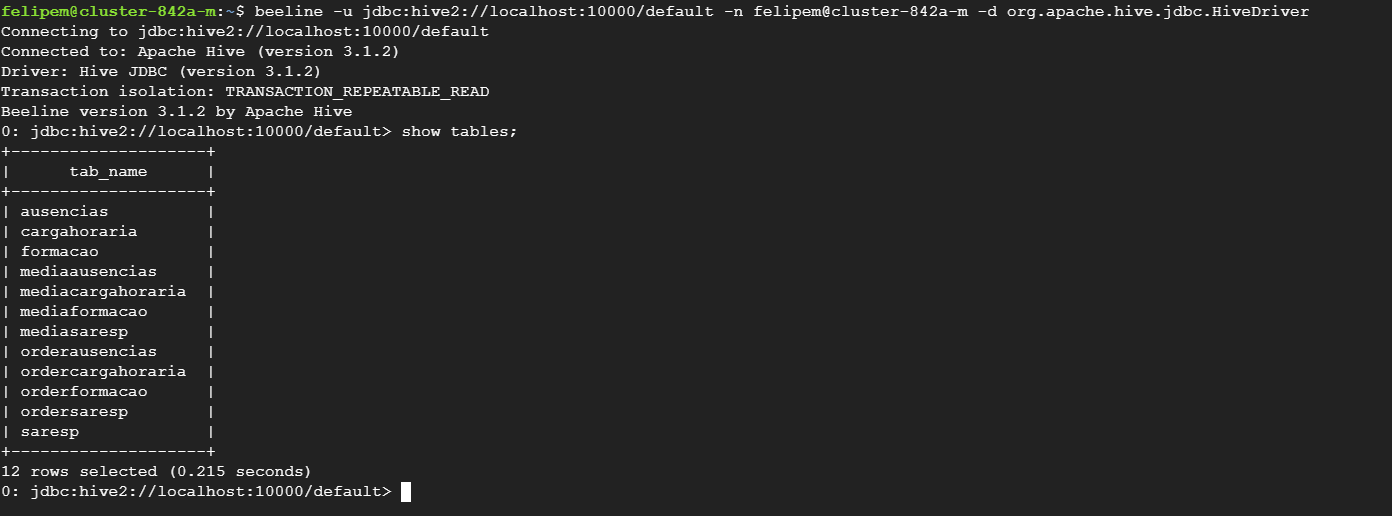

### Passo 5 da Análise de Dados

Com os dados já reduzidos e ordenados, resta apenas a comparação para validar as hípoteses. Isso será feito através do join entre as tabelas. Elas serão ordenadas pelo ranking e limitadas a 30 linhas para fins de análise. Antes, faremos uma breve análise dos valores máximos de cada uma das ordenações. Dessa forma poderemos entender o quão longe estamos da melhor ordenação ao analisar os dados.

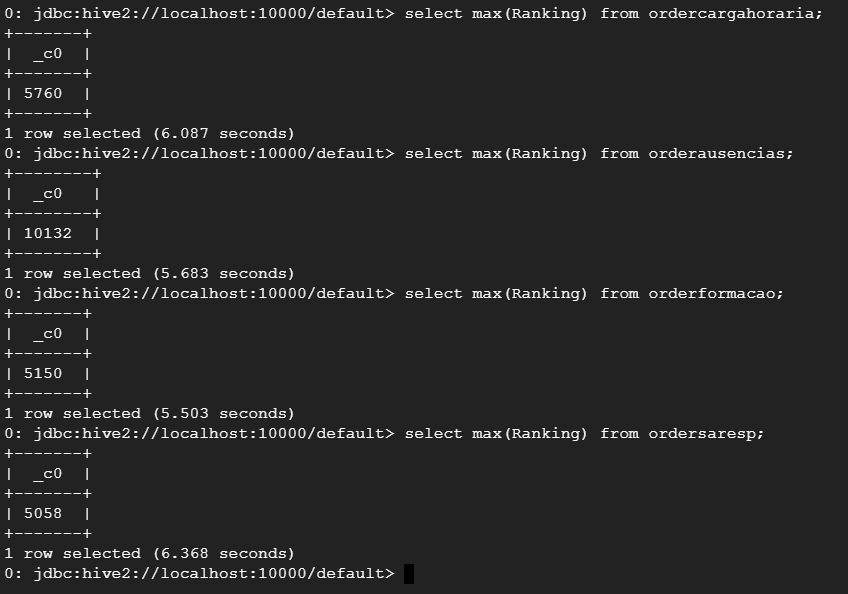

**Por Formação**\


```
Select 
  a.codesc, 
  medprof, 
  a.Ranking , 
  b.Ranking as Ranking_Formacao 
From 
  ordersaresp a 
Left join 
  orderformacao b 
On a.codesc = b. CIEESCOLA  
order by 
  a.Ranking 
limit 30;
```

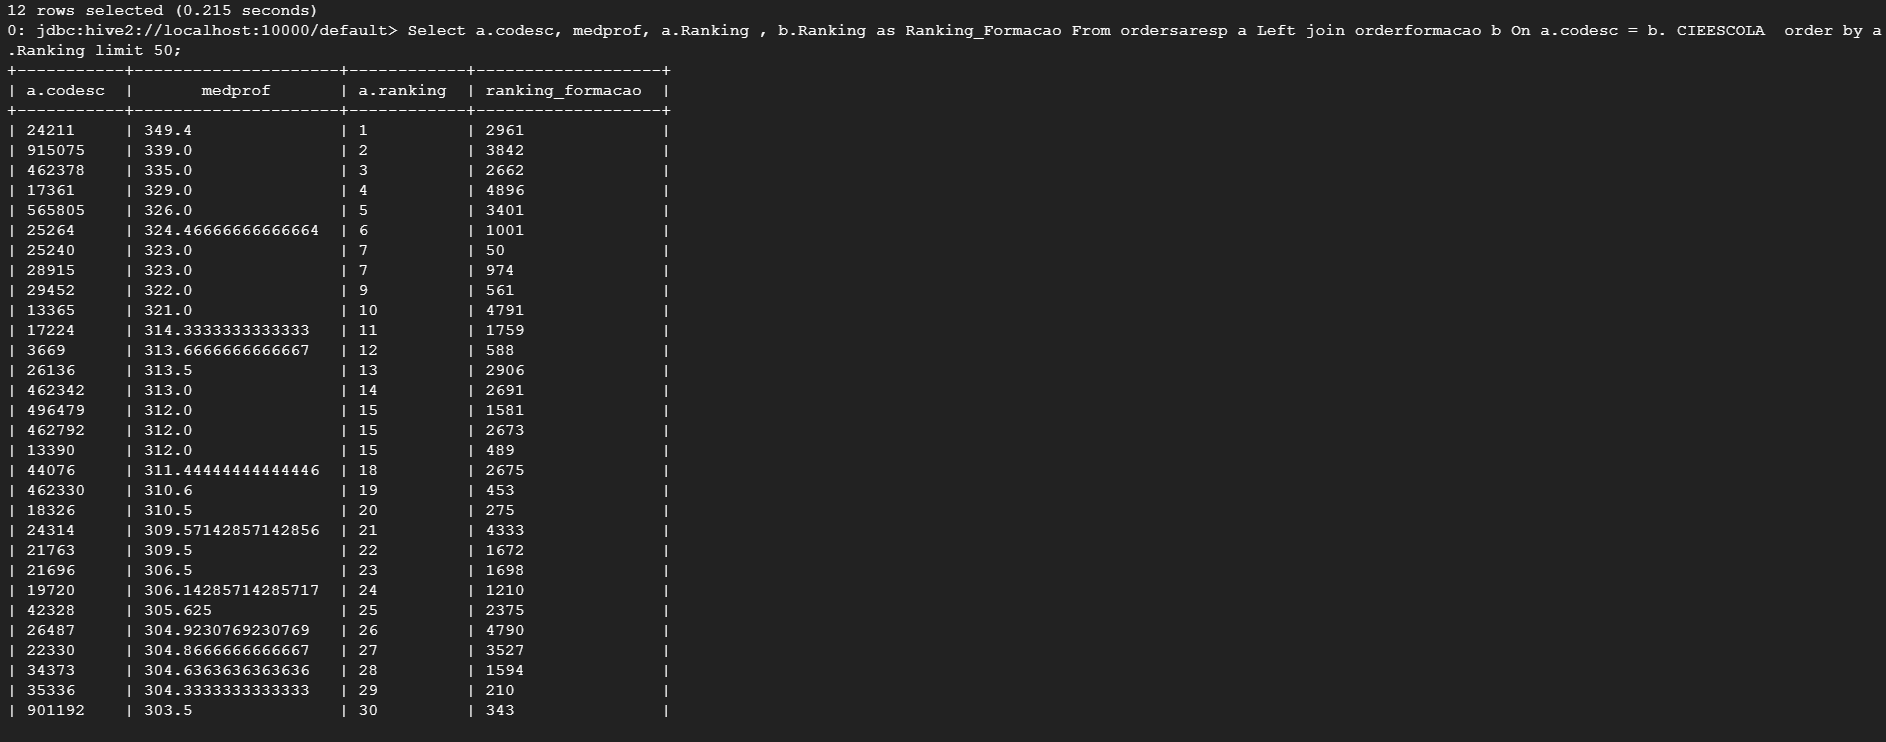


A análise por formação mostra que existe uma relação mas ela talvez não seja forte. As 5 primeiras escolas não estão entre primeiro e segundo quartil das escolas com maior média de formação e apenas a de ranking número 7 está entre as 100 primeiras de maior formação.

**Por Ausências**\



```
Select 
  a.codesc, 
  medprof, 
  a.Ranking , 
  c.Ranking as Ranking_Ausencia 
From 
  ordersaresp a 
Left join 
  orderausencias c 
On a.codesc = c. CIEESCOLA 
order by 
  a.Ranking 
limit 50;
```

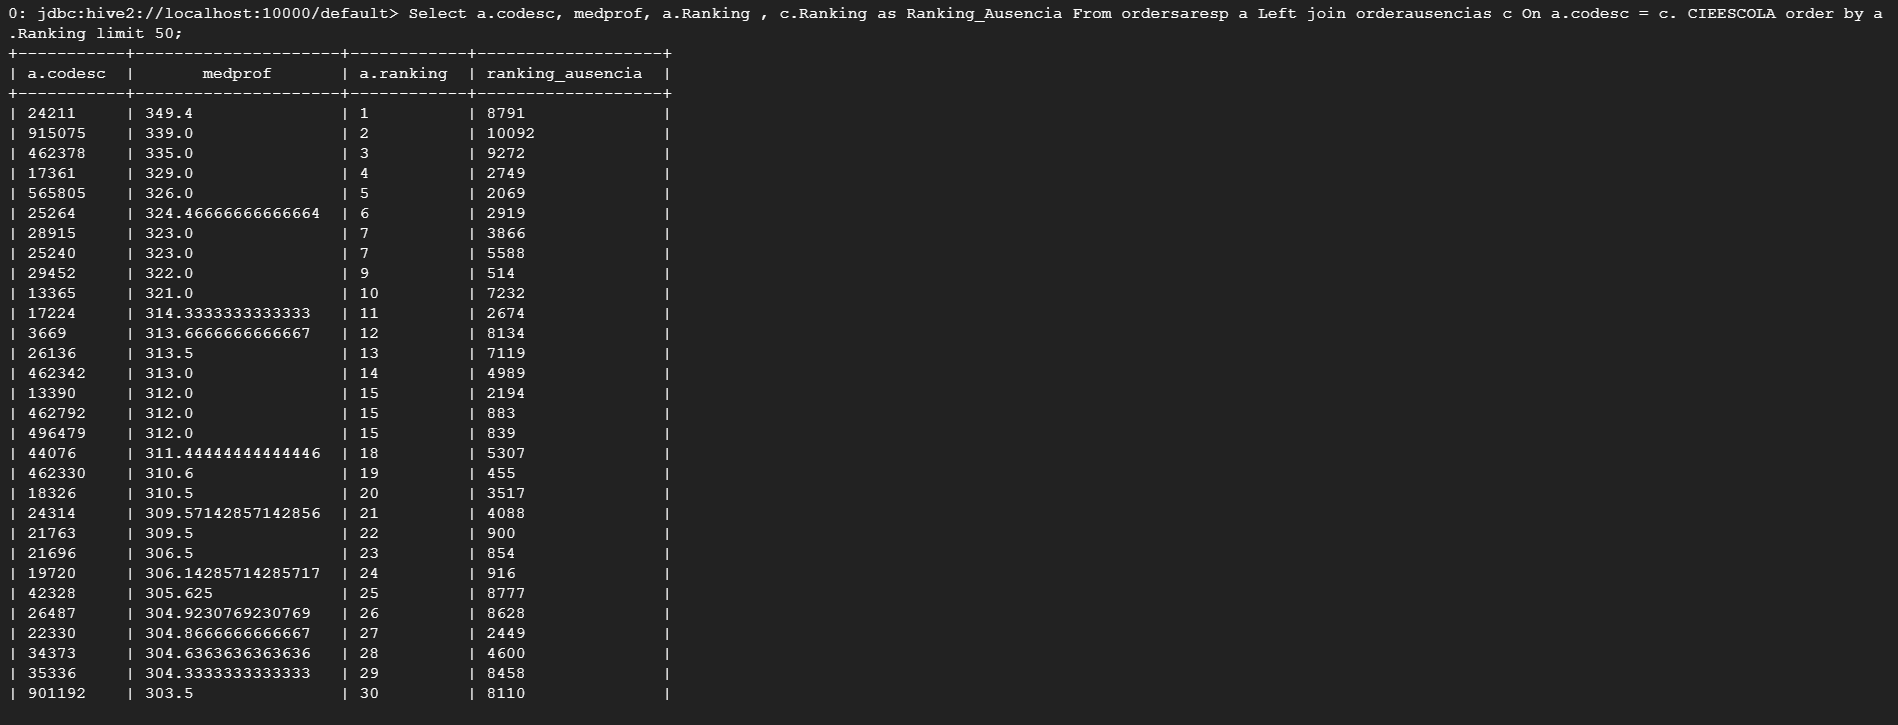

Ao realizarmos o cruzamento e analisarmos os dados, vemos que as ausências talvez representem um bom indicador de análise. As 3 primeiras escolas estão próximas da última colocação em ausências ou seja a menor média de faltas. Isso é uma boa relação, do top 30 poucas escolas estão entre os 10% com mais faltas.

**Por Carga Horária**\



```
Select 
  a.codesc, 
  medprof, 
  a.Ranking , 
  d.Ranking as Ranking_CargaHoraria 
From 
  ordersaresp a 
Left join 
  ordercargahoraria d 
On a.codesc = d. codesc 
order by 
  a.Ranking 
limit 30;
```


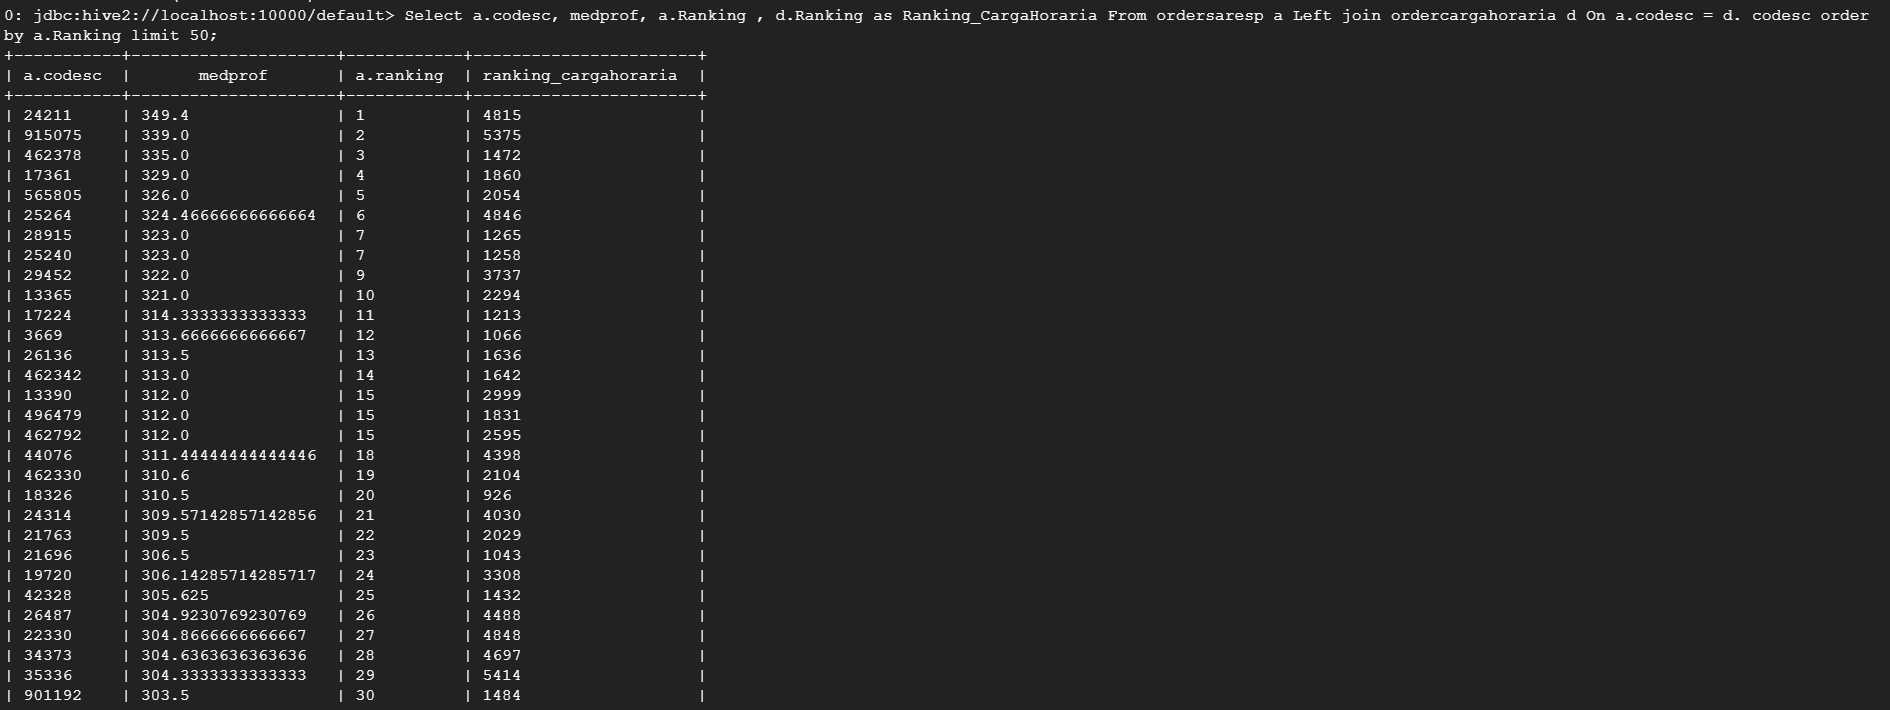

Essa é a relação mais fraca até agora. A maioria das escolas com melhores médias está próxima a mediana de médias em carga horária. Não parece haver correlação

### Conclusão e Próximos Passos

Após a análise foi possível identificar um padrão nos dados mas esse padrão ainda não refletiu grande similaridade com os indicadores escolhidos. Apesar da máxima de que uma melhor formação e maior carga horária aumentariam o nível das escolas públicas foi o volume de ausências o que mais se aproximou de um indicador guia para esse entendimento, sugerindo que talvez políticas de acompanhamento dos profissionais da educação possam ser mais eficazes enquanto investimento.

Em uma próxima etapa do estudo, seria interessante avaliar esses indicadores a partir de outras formas de agrupamento além da média. Tendo dados desde 19 até 22 de forma contínua seria possível avaliar inclusive por séries temporais se o aumento de um determinado indicador faz subir também a avaliação do SARESP e se sua queda faz cair o indicador.